# 1.3.2: World Population (Iteration)

<br>

---

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey, (License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/))

Revised, Mike Augspurger (2021-present)

<br>

---

In the previous notebook we simulated a model of world population with
constant growth. Our first stab at a model was not great, but with some iteration in the exercises we brought our average relative error down to about 2%.  Should we stop there?

<br>

It's tempting, but there's more to understanding data than just fitting the curve.  If you think about the nature of population, a couple tings might be bothering you:

* There is no obvious mechanism that would cause population growth to be constant from year to year. Changes in population are determined by the fraction of people who die and the fraction of people who give birth, so we expect them to depend on the current population.

* According to this model, world population would keep growing at the same rate forever, and that does not seem reasonable.  Even more, the model suggests that this rate of growth would be the same even if the population were tiny.  Somethings not quite right...

As you can see, fitting a curve to data can be a first step understanding data, but it doesn't really *explain* what is happening in the system.  As we iterate, let's look for a model that might both fit the data better and make more explanatory sense.

In [ ]:
#@title
# Import libraries
from os.path import basename, exists
from os import mkdir

def download(url,folder):
    filename = folder + basename(url)
    if not exists(folder):
        mkdir(folder)
    # fetches the file at the given url if it is not already present
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Notebooks/'
        + 'ModSimPy_Functions/modsim.py', 'ModSimPy_Functions/')

from ModSimPy_Functions.modsim import *
import pandas as pd
import numpy as np

---

## Streamlining our Code

Before we try out a new model, let's clean some stuff up. 

### Creating a `System` Object

The first thing we'll do is pull our system parameters, which generally do not change, into a single *system object*.  For example, in the bikeshare model, system parameters include the number of locations, total number of bikes, and arrival rates at each location.  In the linear population model, system parameters include the annual growth rate, the initial population, and the start and end times.

<br>

We'll start by uploading our data and organizing it, just as we did in the last notebook.

In [ ]:
# Read and organize population estimates data
filename = 'https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Images_and_Data/Data/World_population_estimates.html'
# If you are using this notebook offline, you will need to upload this data
# from the Images_and_Data folder on your local computer.  
# Comment out the line above, and uncomment the
# line below this one, and run this cell
# filename = '../Images_and_Data/Data/World_population_estimates.html'

tables = pd.read_html(filename, header=0, index_col=0, decimal='M')
table2 = tables[2]
table2.columns = ['census', 'prb', 'un', 'maddison', 
                  'hyde', 'tanton', 'biraben', 'mj', 
                  'thomlinson', 'durand', 'clark']
un = table2.un / 1e9
census = table2.census / 1e9

Then we can define our system parameters:

In [ ]:
t_0 = census.index[0]
t_end = census.index[-1]
elapsed_time = t_end - t_0

p_0 = census[t_0]
p_end = census[t_end]

total_growth = p_end - p_0
annual_growth = total_growth / elapsed_time

Now we'll pack these parameters into a single `object`.  We'll put the them into a standard Python `dictionary` object here, because it stores paired keys and values:

In [ ]:
system = dict(t_0=t_0, 
               t_end=t_end,
               p_0=p_0,
               annual_growth=annual_growth)

`t0` and `t_end` are the first and last years; `p_0` is the initial
population, and `annual_growth` is the estimated annual growth. Here's what `system` looks like.  

In [ ]:
system

{'t_0': 1950,
 't_end': 2016,
 'p_0': 2.557628654,
 'annual_growth': 0.07224800083333333}

Notice the curly brackets: this indicates that `system` is a dictionary.  In fact, another way to create this `system` dictionary would be to write:

- `system = {'t_0':t_0, 't_end':t_end, 'p_0':p_0, 'annual_growth':annual_growth}`

I prefer to use the `dict()` method, but both are fine and produce the same object.

### Wrapping our simulation process in a function

The next 'streamlining' step we'll take is to wrap the code from the previous chapter in a function:

In [ ]:
def run_simulation_lin(system):
    results = pd.Series([],dtype=object)
    results[system['t_0']] = system['p_0']
    
    for t in range(system['t_0'], system['t_end']):
        results[t+1] = results[t] + system['annual_growth']
    
    return results

`run_simulation_lin` takes a system object and uses the parameters in it to determine `t_0`, `t_end`, and `annual_growth`.  It simulates population growth over time and returns the results in a `Series`.

<br>

✅ Active reading: Add documentation (docstrings and line comments) to the `run_simulation_lin` function.

<br>

Here's how we call the new function.

In [ ]:
results1 = run_simulation_lin(system)

Here's the function we used in the previous chapter to plot the estimates.

In [ ]:
def plot_estimates():
    census.plot(style=':', label='US Census',legend=True)
    un.plot(style='--', label='UN DESA', xlabel='Year', 
             ylabel='World population (billion)',
           legend=True)

And here are the results.

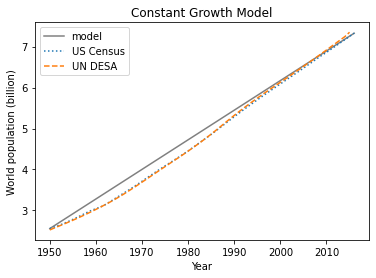

In [ ]:
results1.plot(label='model', color='gray',
              title='Constant Growth Model',legend=True)
plot_estimates()

It might not be obvious that using functions and a system object is a
big improvement, and for a simple model that we run only once, maybe
it's not. But as we work with more complex models, and when we run many simulations with different parameters, we'll see that this way of organizing the code makes a big difference.

<br>

Now let's see if we can improve the model.

<br>

---

## Proportional Growth Model

The biggest problem with the constant growth model is that it doesn't
make any sense. Haha!  That's a big problem!  

<br> Seriously, though, it is hard to imagine how people all over the world
could conspire to keep population growth constant from year to year. 

<br>

One way to understand why this model is faulty is to take it to extremes: if the world population were 7 million instead of 7 billion, is it possible that the growth rate would still be 70 million people per year?

### Birth and death rates

It makes more sense to think of growth and decline in terms of *rates*: some percentage of the population will give birth each year, and a different percentage will die.  Let's create a new `run_simulation` function that computes the annual change in population according to birth and death rates.  Compare the difference between these two models:

In [ ]:
def run_simulation_lin(system):
    results = pd.Series([],dtype=object)
    results[system['t_0']] = system['p_0']
    
    for t in range(system['t_0'], system['t_end']):
        results[t+1] = results[t] + system['annual_growth']
    
    return results

def run_simulation_prop(system):
    results = pd.Series([],dtype=object)
    results[system['t_0']] = system['p_0']
    
    for t in range(system['t_0'], system['t_end']):
        births = system['birth_rate'] * results[t]
        deaths = system['death_rate'] * results[t]
        results[t+1] = results[t] + births - deaths
        
    return results

Each time through the loop, we use the parameter `birth_rate` to compute the number of births, and `death_rate` to compute the number of deaths.
The rest of the function is the same as `run_simulation_lin`.

<br>

Now we can choose the values of `birth_rate` and `death_rate` that best fit the data. 
For the death rate, I'll use 7.7 deaths per 1000 people, which was roughly the global death rate in 2020.

In [ ]:
system['death_rate'] = 7.7 / 1000

We'll choose a birth rate that matches our data.  

<br>

Start with a thought experiment: If both the birth and death rates were 7.7 births per 1000 people, what would happen to the population?  But the population is growing, so we know the birth rate needs to be higher than 7.7. Change the birth rate in the cell below, and rerun the model until it fits the data as closely as possible:

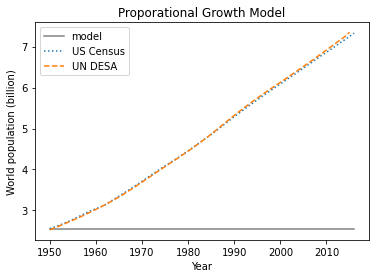

In [ ]:
system['birth_rate'] = 7.7 / 1000
results2 = run_simulation_prop(system)
results2.plot(label='model', color='gray',
              title='Proporational Growth Model',legend=True)
plot_estimates()

Depending on the birth rate we choose, we can get the model to fit the data in the first part of the time period, or we can get the model to match the current population, but doing both doesn't work. Overall,
the *quality of fit* is not as good as the constant growth model,
which is surprising, because it seems like the proportional model is
more realistic.

<br>

We're going to have to keep iterating...

### Adding flexibility by using a function as a parameter

`run_simulation_lin` and `run_simulation_prop` are nearly identical except for the body of the `for` loop, where we compute the population for the next year.  This is an indicator that we should consider an approach that might be more efficient: if your code repeats itself a lot, updating and changing that code becomes laborious and bug-filled.

<br>

Rather than repeat identical code, we can separate the things that
change from the things that don't. First, I'll pull out the births and deaths from `run_simulation_prop` and make a function:

In [ ]:
def change_func_prop(t, pop, system):
    births = system['birth_rate'] * pop
    deaths = system['death_rate'] * pop
    return births - deaths

`change_func_prop` takes as arguments the current year, current population, and a `System` object; it returns the net population growth during the current year.  This function does not use `t`, so we could leave it out. But we will see other growth functions that need it, and it is convenient if they all take the same parameters, used or not. 

<br>

Now we can write a function that runs with any `change_func` that we might want to define:

In [ ]:
def run_simulation(system, change_func):
    results = pd.Series([],dtype=object)
    results[system['t_0']] = system['p_0']
    
    for t in range(system['t_0'], system['t_end']):
        growth = change_func(t, results[t], system)
        results[t+1] = results[t] + growth
        
    return results

This function demonstrates a feature we have not seen before: it takes a
function as a parameter! When we call `run_simulation`, the second
parameter is a function, like `change_func_prop`, that computes the
population for the next year.  Here's how we call it:

In [ ]:
results = run_simulation(system, change_func_prop)

Passing a function as an argument is the same as passing any other
value. The argument, which is `change_func_prop` in this example, gets
assigned to the parameter, which is called `change_func`. Inside
`run_simulation`, we can call `change_func` just like any other function.  Each time through the loop, `run_simulation` calls `change_func_prop` to compute net growth, and uses it to compute the population during the next year.

<br>

✅ Active Reading:  Add documentation (docstrings and line comments for each line) to this new version of run_simulation

### Combining Birth and Death

We can simplify the code slightly by combining births and deaths to compute the net growth rate. 
Instead of two parameters, `birth_rate` and `death_rate`, we can write the change function in terms of a single parameter that represents the difference:

In [ ]:
system['alpha'] = system['birth_rate'] - system['death_rate']
system['alpha']

0.0

The name of this parameter, `alpha`, is the conventional name for a
proportional growth rate.  Here's the modified version of `change_func_prop`:

In [ ]:
def change_func_prop(t, pop, system):
    annual_growth = system['alpha'] * pop
    return annual_growth

And here's how we run it:

In [ ]:
results = run_simulation(system, change_func_prop)

The results are the same as the previous versions, but now the code is organized in a way that makes it easy to explore other models.

<br>

---

## Summary and Exercises

In this chapter, we:

* wrapped the code from the previous chapter in functions and used a `System` object to store the parameters of the system.

* explored a new model of population growth, where the number of births and deaths is proportional to the current population.  This model seems more realistic, but it turns out not to fit the data particularly well.

In the next chapter, we'll continue to iterate, using a third analytical model for growth.

<br>

---

### Exercise 1

✅ 
Maybe the reason the proportional model doesn't work very well is that the growth rate, `alpha`, is changing over time.  So let's try a model with different growth rates before and after 1980 (as an arbitrary choice).

<br>

Write an updated change function that takes `t`, `pop`, and `system` as parameters.  The system object, `system`, should contain two parameters: the growth rate before 1980, `alpha1`, and the growth rate after 1980, `alpha2`.  The function should use `t` to determine which growth rate to use.

<br>

Test your function by calling it directly, then pass it to `run_simulation`.  Plot the results.  Adjust the parameters `alpha1` and `alpha2` to fit the data as well as you can.

In [ ]:
# Create new change function using alpha1 and alpha2


In [ ]:
# Define system object that includes alpha1 and alpha2



# Test the new change function by calling it with an easy to calculate 
# population (like 10) and changing 't' to make sure you get the correct 
# answer
growth = change_func_prop_change(1950,10,system)
print(growth)


NameError: ignored

In [ ]:
# Run using run_simulation and plot results


### Exercise 2

✅
We can get better results by changing our growth rate `alpha`.  But like the linear model, this iteration doesn't make good explanatory sense: why would the growth rate suddenly change in 1980?   

Try one more proportional change function here, but have the growth rate change gradually.  You can do this either by multiplying `alpha` each year or subtracting from it.  There are numerous ways to code this, too.  Notice, though, that if you want to, you can permanantly update `system['alpha']` each time the change function using a line such as `system['alpha'] = system['alpha'] + 1` or `system['alpha'] = system['alpha'] * 0.7`

In [ ]:
# Create new growth function


In [ ]:
# Define the system and test the new function (just like in exercise 1)


In [ ]:
# Run using run_simulation and plot results
